In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Part 1: Exploratory Data Analysis

## 1.Read JSON to pandas DataFrame

In [2]:
logins_df=pd.read_json('logins.json', orient='records')

## 2. Data Wrangling

In [3]:
logins_df.describe()

,login_time
count,93142
unique,92265
top,1970-02-12 11:16:53
freq,3
first,1970-01-01 20:12:16
last,1970-04-13 18:57:38


The data contains 93141 timestamp from 01/01/1970 to 04/13/1970, the data set has duplicate values.

In [4]:
logins_df.head(5)

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [5]:
logins_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
login_time    93142 non-null datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [6]:
indexed_logins_df = logins_df.set_index(['login_time'])
indexed_logins_df.head()

""
login_time
1970-01-01 20:13:18
1970-01-01 20:16:10
1970-01-01 20:16:37
1970-01-01 20:16:36
1970-01-01 20:26:21


Here I am setting the index to be the login time so we are able to count how many clicks in 15mins time interval.

In [7]:
indexed_logins_df['count'] = 1
indexed_logins_df_15T = indexed_logins_df.resample('15T').count()
indexed_logins_df_15T = indexed_logins_df_15T.reset_index()
indexed_logins_df_15T.head()

,login_time,count
0,1970-01-01 20:00:00,2
1,1970-01-01 20:15:00,6
2,1970-01-01 20:30:00,9
3,1970-01-01 20:45:00,7
4,1970-01-01 21:00:00,1


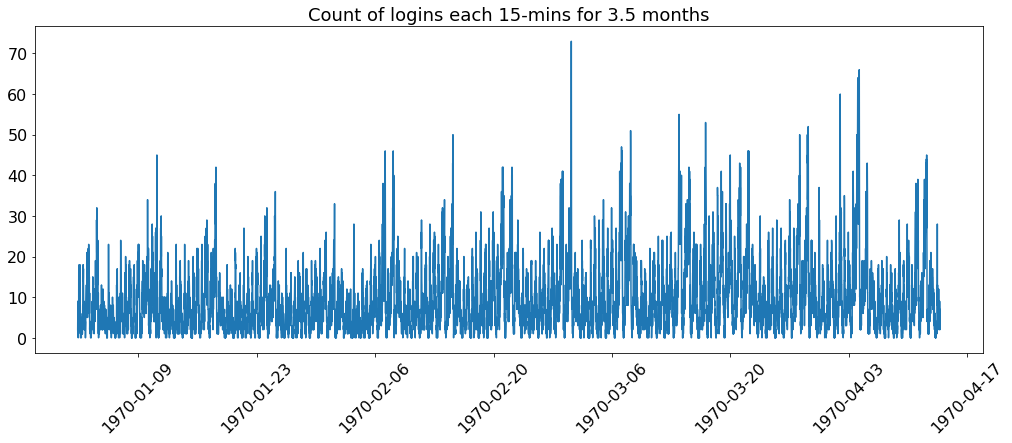

In [8]:
x = indexed_logins_df_15T['login_time']
y = indexed_logins_df_15T['count']
plt.figure(figsize=(17,6))
_=plt.plot(x, y)
_=plt.tick_params(labelsize=16)
plt.title('Count of logins each 15-mins for 3.5 months',fontsize=18)
plt.xticks(rotation=45);

The overall trend seems periodic, now let's see if it changes over months, weeks or days.

In [9]:
def logins_month(start,end):
    return indexed_logins_df_15T[(indexed_logins_df_15T.login_time > start)& (indexed_logins_df_15T.login_time < end)]

In [10]:
jan=logins_month('1970-01','1970-02')
feb=logins_month('1970-02','1970-03')
mar=logins_month('1970-03','1970-04')
apr=logins_month('1970-04','1970-05')

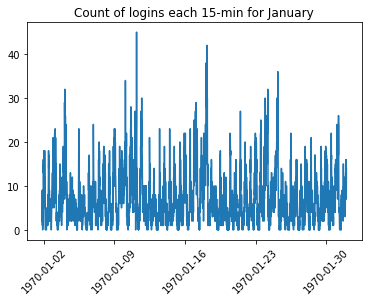

In [11]:
# January
x = jan['login_time']
y = jan['count']
plt.plot(x, y)
plt.title('Count of logins each 15-min for January')
plt.xticks(rotation=45);

<Figure size 432x288 with 0 Axes>

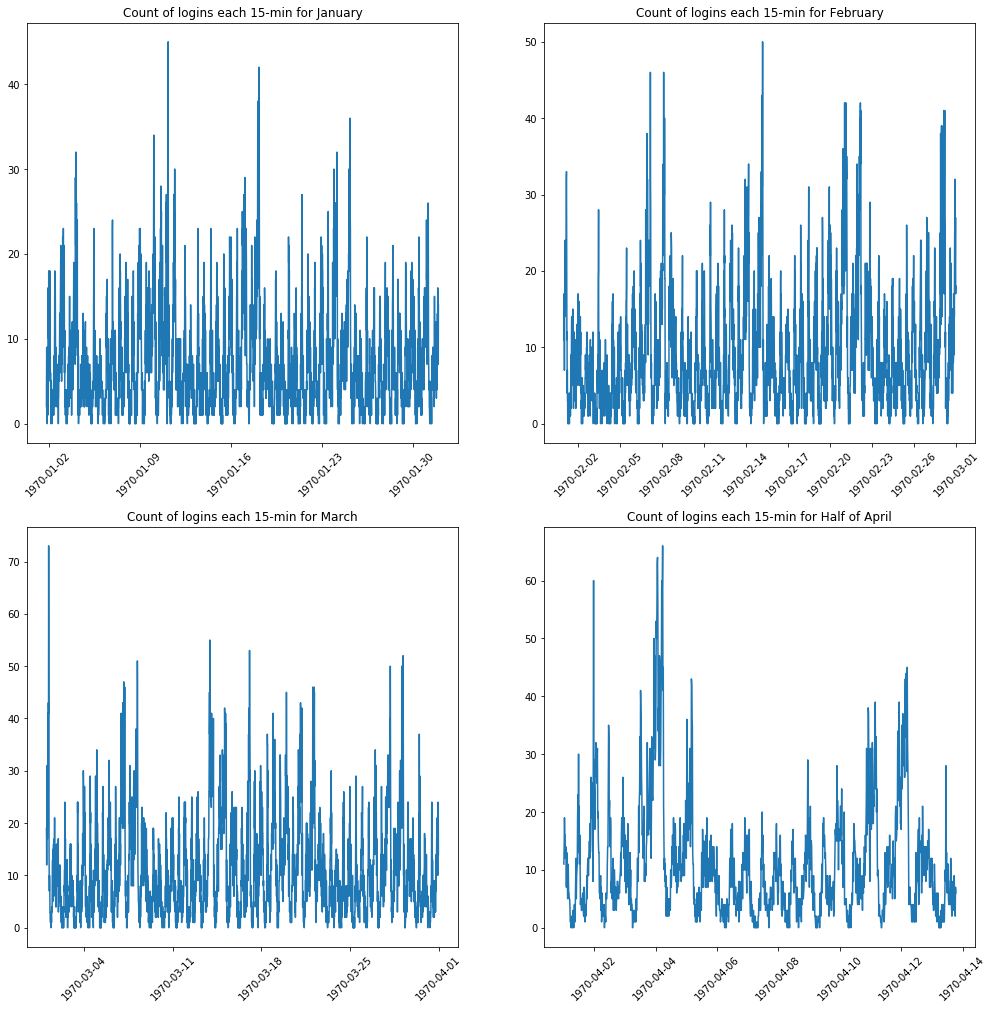

In [12]:
fig = plt.figure()
plt.figure(figsize=(17,17))
plt.subplot(2, 2, 1)
x = jan['login_time']
y = jan['count']
plt.plot(x, y)
plt.title('Count of logins each 15-min for January')
plt.xticks(rotation=45);

plt.subplot(2, 2, 2)
x = feb['login_time']
y = feb['count']
plt.plot(x, y)
plt.title('Count of logins each 15-min for February')
plt.xticks(rotation=45);

plt.subplot(2, 2, 3)
x = mar['login_time']
y = mar['count']
plt.plot(x, y)
plt.title('Count of logins each 15-min for March')
plt.xticks(rotation=45);
plt.subplot(2, 2, 4)
x = apr['login_time']
y = apr['count']
plt.plot(x, y)
plt.title('Count of logins each 15-min for Half of April')
plt.xticks(rotation=45);


For logins per week, we can still notice periodic behavior so now let's take a look at logins weekly.

In [13]:
indexed_logins_df_15T['weekday'] = indexed_logins_df_15T['login_time'].dt.dayofweek
wkday = indexed_logins_df_15T.sort_values(by='count', ascending=False)
wkday_counts = wkday[['count', 'weekday']]
wkday_count = wkday_counts.groupby('weekday').sum().reset_index()

In [14]:
wkday_count['weekday'] = ['Mon', 'Tues', 'Wed','Thurs','Fri', 'Sat', 'Sun']
wkday_count = wkday_count[['weekday', 'count']]
wkday_count

,weekday,count
0,Mon,8823
1,Tues,9268
2,Wed,10339
3,Thurs,11960
4,Fri,15208
5,Sat,19377
6,Sun,18167


Text(0.5,1,'Count of logins vs. Weekday for 3.5 Months')

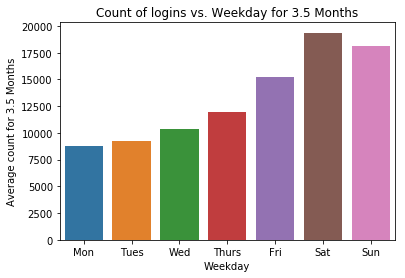

In [15]:
sns.barplot(x='weekday', y='count', data=wkday_count)

plt.ylabel('Average count for 3.5 Months')
plt.xlabel('Weekday')
plt.title('Count of logins vs. Weekday for 3.5 Months')

The trend seems to be very obvious here, weekends will have more logins than weekends, Saturdays have more logins than Sundays.

In [16]:
indexed_logins_df_15T['hour'] = indexed_logins_df_15T[
    'login_time'].dt.hour
hours = indexed_logins_df_15T
hour = hours[['count', 'hour']]
hour = hour.groupby('hour').sum().reset_index()
hour.head()

,hour,count
0,0,5993
1,1,6317
2,2,5800
3,3,4831
4,4,5034


Text(0.5,1,'Average count of logins vs. Hour of day for 3.5 Months')

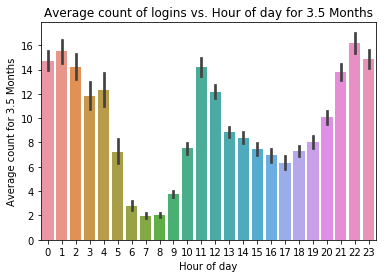

In [17]:
sns.barplot(x='hour', y='count', data=hours)
plt.ylabel('Average count for 3.5 Months')
plt.xlabel('Hour of day')
plt.title('Average count of logins vs. Hour of day for 3.5 Months')

The logins number is high during midnight (9pm to 2am) and lunch time (11am to 12 pm).

# Part2: Experiment and metrics design

  ### The    neighboring     cities    of    Gotham    and    Metropolis    have     complementary     circadian     rhythms:     on  weekdays,    Ultimate    Gotham     is    most     active    at    night,    and    Ultimate    Metropolis     is    most    active  during     the    day.    On    weekends,     there     is     reasonable    activity     in    both     cities.    
  
  ### However,    a     toll    bridge,     with     a     two  ­way     toll,    between     the     two     cities     causes    driver    partners     to     tend  to    be    exclusive     to    each     city.     The     Ultimate    managers    of     city    operations     for     the     two     cities    have  proposed    an    experiment     to     encourage    driver    partners     to    be    available     in    both     cities,    by  reimbursing    all     toll     costs.

### Q1: What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?

### A1: The key measure of success to evaluate this experiment is the profit difference between the experiments.

### Q2: Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:

### how you will implement the experiment.
### what statistical test(s) you will conduct to verify the significance of the observation.
### how you would interpret the results and provide recommendations to the city operations team along with any caveats.

### A2: I will use a A/B testing to study this experiment. Let's record the profit data for first there is still toll costs and after one week( or month) let's reimburse all toll costs and record the profit data again. Then use a T-test to figure out if there is any significant difference between two profits at 95% confidence level. If profit increase, we shoud continue do this, if not increase or decrease we shoud still keep toll costs.

# Part 3: Predictive modeling

In [18]:
import json
file = open('ultimate_data_challenge.json', 'r')
df = pd.DataFrame(json.load(file))
file.close()
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     49604 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


There are some missing values in avg_rating_by_driver,avg_rating_of_driver and phone column, I will fill in first two with mean and drop missing value in the phone column.

In [20]:
df['avg_rating_by_driver'].fillna(df['avg_rating_by_driver'].mean(), inplace=True)
df['avg_rating_of_driver'].fillna(df['avg_rating_of_driver'].mean(), inplace=True)
df=df.dropna()

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49604 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  49604 non-null float64
avg_rating_by_driver      49604 non-null float64
avg_rating_of_driver      49604 non-null float64
avg_surge                 49604 non-null float64
city                      49604 non-null object
last_trip_date            49604 non-null object
phone                     49604 non-null object
signup_date               49604 non-null object
surge_pct                 49604 non-null float64
trips_in_first_30_days    49604 non-null int64
ultimate_black_user       49604 non-null bool
weekday_pct               49604 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.6+ MB


In [22]:
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])
df['signup_date'] = pd.to_datetime(df['signup_date'])

In [23]:
trips_city = (df[['trips_in_first_30_days', 'city', 'phone']].groupby('city').sum().reset_index())
trips_city

,city,trips_in_first_30_days
0,Astapor,31951
1,King's Landing,24820
2,Winterfell,56190


Text(0.5,1,'Trips vs. City')

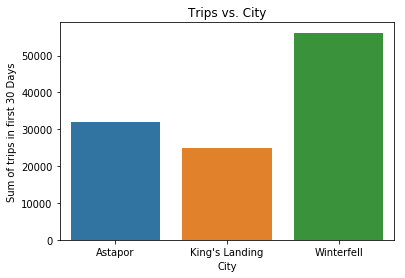

In [24]:
sns.barplot(x='city', y='trips_in_first_30_days', data=trips_city)
plt.ylabel('Sum of trips in first 30 Days')
plt.xlabel('City')
plt.title('Trips vs. City')

In [25]:
trips_phone= df[['trips_in_first_30_days', 'city', 'phone']].groupby('phone').sum().reset_index()
trips_phone

,phone,trips_in_first_30_days
0,Android,29067
1,iPhone,83894


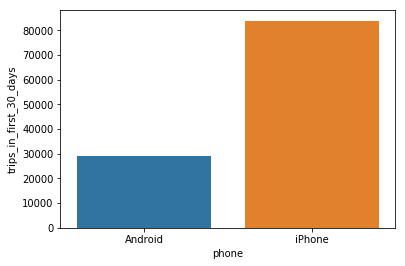

In [26]:
sns.barplot(x='phone', y='trips_in_first_30_days', data=trips_phone)

In [27]:
df[['last_trip_date']].max()
len(df[df['last_trip_date'] >= '2014-06-01'])

18671

In [28]:
len(df[df['last_trip_date'] < '2014-06-01'])

30933

In [30]:
df['retained'] = np.nan
df.loc[df['last_trip_date'] >= '2014-06-01', 'retained'] = 1
df.loc[df['last_trip_date'] < '2014-06-01', 'retained'] = 0
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,retained
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2,1.0
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0,0.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0,0.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0,1.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4,0.0


In [31]:
df['retained'].sum()/len(df)

0.37640109668575117

## Predictive model

In [32]:
df.drop('last_trip_date', axis=1, inplace=True)
df.drop('signup_date', axis=1, inplace=True)
y = df['retained'].values
df = df.drop('retained', axis=1)

Encoding all categorical features

In [33]:
df_encoded = pd.get_dummies(df, columns = ['city', 'phone', 'ultimate_black_user'])
df_encoded.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone,ultimate_black_user_False,ultimate_black_user_True
0,3.67,5.0,4.7,1.10,15.4,4,46.2,0,1,0,0,1,0,1
1,8.26,5.0,5.0,1.00,0.0,0,50.0,1,0,0,1,0,1,0
2,0.77,5.0,4.3,1.00,0.0,3,100.0,1,0,0,0,1,1,0
3,2.36,4.9,4.6,1.14,20.0,9,80.0,0,1,0,0,1,0,1
4,3.13,4.9,4.4,1.19,11.8,14,82.4,0,0,1,1,0,1,0


In [34]:
X = df_encoded.values

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [37]:
X_train[0]

array([ 4.59,  4.9 ,  4.8 ,  1.09, 17.2 ,  3.  , 79.3 ,  1.  ,  0.  ,
        0.  ,  0.  ,  1.  ,  1.  ,  0.  ])

In [39]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [40]:
X_train[0]

array([-0.21244966,  0.27532593,  0.34990314,  0.0651802 ,  0.41450442,
        0.18835806,  0.49720727,  1.42175766, -0.50501141, -0.93381809,
       -0.65980725,  0.65980725,  0.77617466, -0.77617466])

## Use neural network as predictive model

In [43]:
import tensorflow
import keras
from keras.models import Sequential
from keras.layers import Dense

Using TensorFlow backend.


In [44]:
classifier = Sequential()

In [45]:
classifier.add(Dense(units = 7, kernel_initializer = 'uniform', activation = 'relu', input_dim = 14))
classifier.add(Dense(units = 7, kernel_initializer = 'uniform', activation = 'relu'))
classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

In [46]:
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [47]:
classifier.fit(X_train, y_train, batch_size = 16, epochs = 10)

Epoch 1/10
39683/39683 [==============================] - 2s 52us/step - loss: 0.5428 - acc: 0.7324
Epoch 2/10
39683/39683 [==============================] - 2s 48us/step - loss: 0.5051 - acc: 0.7585: 1s -
Epoch 3/10
39683/39683 [==============================] - ETA: 0s - loss: 0.4932 - acc: 0.767 - 2s 48us/step - loss: 0.4934 - acc: 0.7673
Epoch 4/10
39683/39683 [==============================] - 2s 47us/step - loss: 0.4888 - acc: 0.7711
Epoch 5/10
39683/39683 [==============================] - 2s 48us/step - loss: 0.4866 - acc: 0.7726
Epoch 6/10
39683/39683 [==============================] - 2s 48us/step - loss: 0.4850 - acc: 0.7741
Epoch 7/10
39683/39683 [==============================] - 2s 48us/step - loss: 0.4838 - acc: 0.7743
Epoch 8/10
39683/39683 [==============================] - 2s 48us/step - loss: 0.4827 - acc: 0.7741
Epoch 9/10
39683/39683 [==============================] - 2s 48us/step - loss: 0.4809 - acc: 0.7766
Epoch 10/10
39683/39683 [==============================]

In [48]:
y_pred = classifier.predict(X_test)
y_pred = (y_pred > 0.5)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[5272  891]
 [1418 2340]]


In [49]:
pos, neg = cm
tp, fp = pos
fn, tn = neg
print('True Positives:', tp)
print('True Negatives:', tn)
print('False Positives:', fp)
print('False Negatives:', fn)

True Positives: 5272
True Negatives: 2340
False Positives: 891
False Negatives: 1418


In [50]:
print('Accuracy:', (tp+tn)/(tp+tn+fp+fn))

Accuracy: 0.767261364781776


In [51]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from keras.models import Sequential
from keras.layers import Dense
def build_classifier():
    classifier = Sequential()
    classifier.add(Dense(units = 7, kernel_initializer = 'uniform', activation = 'relu', input_dim = 14))
    classifier.add(Dense(units = 7, kernel_initializer = 'uniform', activation = 'relu'))
    classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
    classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    return classifier

In [52]:
classifier = KerasClassifier(build_fn = build_classifier, batch_size = 16, epochs = 10)
accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10)

Epoch 1/10
35714/35714 [==============================] - 2s 55us/step - loss: 0.5494 - acc: 0.7275
Epoch 2/10
35714/35714 [==============================] - 2s 49us/step - loss: 0.5095 - acc: 0.7546
Epoch 3/10
35714/35714 [==============================] - 2s 49us/step - loss: 0.4935 - acc: 0.7662: 0s - loss: 0.49
Epoch 4/10
35714/35714 [==============================] - 2s 48us/step - loss: 0.4869 - acc: 0.7702
Epoch 5/10
35714/35714 [==============================] - 2s 48us/step - loss: 0.4841 - acc: 0.7736
Epoch 6/10
35714/35714 [==============================] - 2s 49us/step - loss: 0.4826 - acc: 0.7760: 0s - loss: 0.4830 - acc: 0.77
Epoch 7/10
35714/35714 [==============================] - 2s 49us/step - loss: 0.4814 - acc: 0.7752
Epoch 8/10
35714/35714 [==============================] - 2s 48us/step - loss: 0.4806 - acc: 0.7750
Epoch 9/10
35714/35714 [==============================] - 2s 48us/step - loss: 0.4800 - acc: 0.7768
Epoch 10/10
3969/3969 [=============================

35715/35715 [==============================] - 2s 50us/step - loss: 0.4940 - acc: 0.7668
Epoch 8/10
35715/35715 [==============================] - 2s 51us/step - loss: 0.4931 - acc: 0.7680
Epoch 9/10
35715/35715 [==============================] - 2s 51us/step - loss: 0.4921 - acc: 0.7692
Epoch 10/10
3968/3968 [==============================] - 0s 52us/step
Epoch 1/10
35715/35715 [==============================] - 2s 60us/step - loss: 0.5452 - acc: 0.7266
Epoch 2/10
35715/35715 [==============================] - 2s 51us/step - loss: 0.5063 - acc: 0.7580
Epoch 3/10
35715/35715 [==============================] - ETA: 0s - loss: 0.4948 - acc: 0.766 - 2s 51us/step - loss: 0.4950 - acc: 0.7659
Epoch 4/10
35715/35715 [==============================] - 2s 51us/step - loss: 0.4895 - acc: 0.7701
Epoch 5/10
35715/35715 [==============================] - 2s 50us/step - loss: 0.4871 - acc: 0.7722
Epoch 6/10
35715/35715 [==============================] - 2s 51us/step - loss: 0.4852 - acc: 0.7728
Epo

In [55]:
mean  =  accuracies.mean()
variance = accuracies.std()
print('Average: ', ('%.4f' % mean))
print('Standard Deviation: ', ('%.4f' % variance))

Average:  0.7750
Standard Deviation:  0.0063


In [56]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense

In [57]:
def build_classifier(optimizer):
    classifier = Sequential()
    classifier.add(Dense(units = 7, kernel_initializer = 'uniform', activation = 'relu', input_dim = 14))
    classifier.add(Dense(units = 7, kernel_initializer = 'uniform', activation = 'relu'))
    classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
    classifier.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])
    return classifier
classifier = KerasClassifier(build_fn = build_classifier)

In [58]:
parameters = {'batch_size': [16, 32],
              'epochs': [10, 50],
              'optimizer': ['adam', 'rmsprop']}

In [64]:
# grid_search = GridSearchCV(estimator = classifier,
#                            param_grid = parameters,
#                             scoring = 'accuracy',
#                             cv = 10)
# grid_search = grid_search.fit(X_train, y_train)
# best_parameters = grid_search.best_params_
# best_accuracy = grid_search.best_score_

In [62]:
print('Best average: ', ('%.4f' % best_accuracy))

Best average:  0.7774


In [63]:
retained = pd.DataFrame(y)
retained.columns = ['retained']
pd.concat([df_encoded, retained],
          axis=1).corr().iloc[14].sort_values(
    ascending=False)

retained                     1.000000
city_King's Landing          0.003415
phone_Android                0.002947
avg_rating_of_driver         0.001444
ultimate_black_user_False    0.001437
avg_surge                   -0.000173
city_Winterfell             -0.000830
avg_dist                    -0.001143
ultimate_black_user_True    -0.001437
surge_pct                   -0.001945
city_Astapor                -0.002040
avg_rating_by_driver        -0.002830
phone_iPhone                -0.002947
weekday_pct                 -0.008710
trips_in_first_30_days      -0.011029
Name: retained, dtype: float64